In [1]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select distinct geometry from landing_points left join cable_coor on cable_id = id",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [3]:
cable_coor

,geometry
0,MULTILINESTRING ((-74.2052931188053 11.2419380...
1,MULTILINESTRING ((-146.35343293589432 61.13035...
2,MULTILINESTRING ((18.701330987741642 59.759755...
3,MULTILINESTRING ((7.426728974775415 43.7382556...
4,MULTILINESTRING ((32.529931191431416 29.972545...
...,...
504,MULTILINESTRING ((129.92498219586352 -10.01151...
505,MULTILINESTRING ((119.92498927995226 18.678647...
506,MULTILINESTRING ((-88.29445457772995 17.925607...
507,MULTILINESTRING ((-46.328062944825774 -23.9618...


In [4]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor.iloc[2].split(', (')

data = pd.DataFrame()

for row in range(cleaned_cable_coor.shape[0]):
    coor_list = cleaned_cable_coor.iloc[row].split(', (')
    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1]}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        data = data.append(seg.dropna(),ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_43175/2491647926.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


,lon1,lat1,lon2,lat2
0,-74.362373,11.331481,-74.205293,11.241938
1,-74.474873,11.221153,-74.362373,11.331481
2,-74.611933,11.012161,-74.474873,11.221153
3,-75.149873,11.073983,-74.952802,11.005163
4,-75.262372,10.963557,-75.149873,11.073983
...,...,...,...,...
9706,-50.849890,-34.487754,-47.699892,-32.612760
9707,-53.549888,-35.226267,-50.849890,-34.487754
9708,-54.950187,-34.900416,-53.549888,-35.226267
9709,-53.999888,-35.593029,-53.549888,-35.226267


In [5]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [48]:
data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])
gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])

# gdf['distance_from_previous'] = gdf.distance(gdf.shift(1))

In [49]:
gdf = gdf.iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column
geo_df = gpd.GeoDataFrame(gdf, geometry=gdf['line'])

<AxesSubplot:>

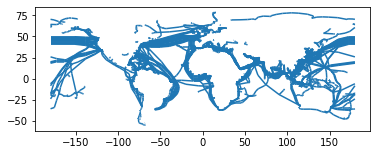

In [50]:
gdf.plot()

In [51]:
gdf = gdf.reset_index( )


In [53]:
gdf.to_csv('/Users/dijiongyuequ/Downloads/345.csv')

In [52]:
gdf.sample(5)

,index,lon1,lat1,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,line,geometry
9296,9297,57.825033,-20.995132,57.600033,-20.679707,POINT (57.82503 -20.99513),POINT (57.60003 -20.67971),3682990.0,3692032.0,0.387450,LINESTRING (57.82503327214377 -20.995131543025...,"LINESTRING (57.82503 -20.99513, 57.60003 -20.6..."
8527,8528,-6.074881,50.311167,-7.649920,49.587287,POINT (-6.07488 50.31117),POINT (-7.64992 49.58729),4423629.0,4193737.0,1.733422,LINESTRING (-6.074881460557094 50.311167251610...,"LINESTRING (-6.07488 50.31117, -7.64992 49.58729)"
6871,6872,44.550043,12.285834,45.450042,12.505588,POINT (44.55004 12.28583),POINT (45.45004 12.50559),5683587.0,5795563.0,0.926440,LINESTRING (44.55004267627157 12.2858335562682...,"LINESTRING (44.55004 12.28583, 45.45004 12.50559)"
3880,3881,58.950032,18.038005,60.075032,19.104405,POINT (58.95003 18.03801),POINT (60.07503 19.10441),7698804.0,7917944.0,1.550107,LINESTRING (58.950032475183775 18.038005439608...,"LINESTRING (58.95003 18.03801, 60.07503 19.10441)"
4274,4275,48.600040,12.505588,45.450042,11.735650,POINT (48.60004 12.50559),POINT (45.45004 11.73565),6110563.0,5718569.0,3.242729,LINESTRING (48.600039807215495 12.505588131780...,"LINESTRING (48.60004 12.50559, 45.45004 11.73565)"


In [68]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'distance_from_previous'], create_using=nx.Graph)


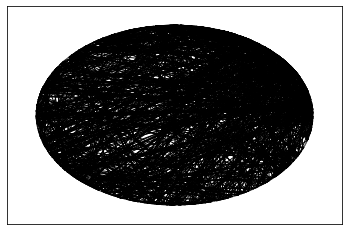

In [55]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [89]:
path = nx.shortest_path(G,6181995, 4629267, weight = 'length')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad

In [86]:
path1 = nx.shortest_path(G,6181995, 10373031, weight = 'length')
# path2 = nx.shortest_path(G,2943486, 10373031, weight = 'length')


# set(path1).difference(set(path2))

In [84]:
path

[6158154,
 6108498.0,
 6161237.0,
 5946574.0,
 5802138.0,
 5704087.0,
 5476984.0,
 5170229.0,
 4977399.0,
 4929928.0,
 4958579.0,
 4983242.0,
 5024197.0,
 4937895.0,
 4838279.0,
 4703424.0,
 4334558.0,
 3983986.0,
 3371805.0,
 3137695.0,
 3034301.0,
 3080844.0,
 3029752.0,
 2957695.0,
 2705905.0,
 2652200.0,
 2669559.0,
 2619840.0,
 3055160.0,
 3925431.0,
 4193737.0,
 4423629.0,
 4628380.0,
 4618691.0,
 4629267]

<AxesSubplot:>

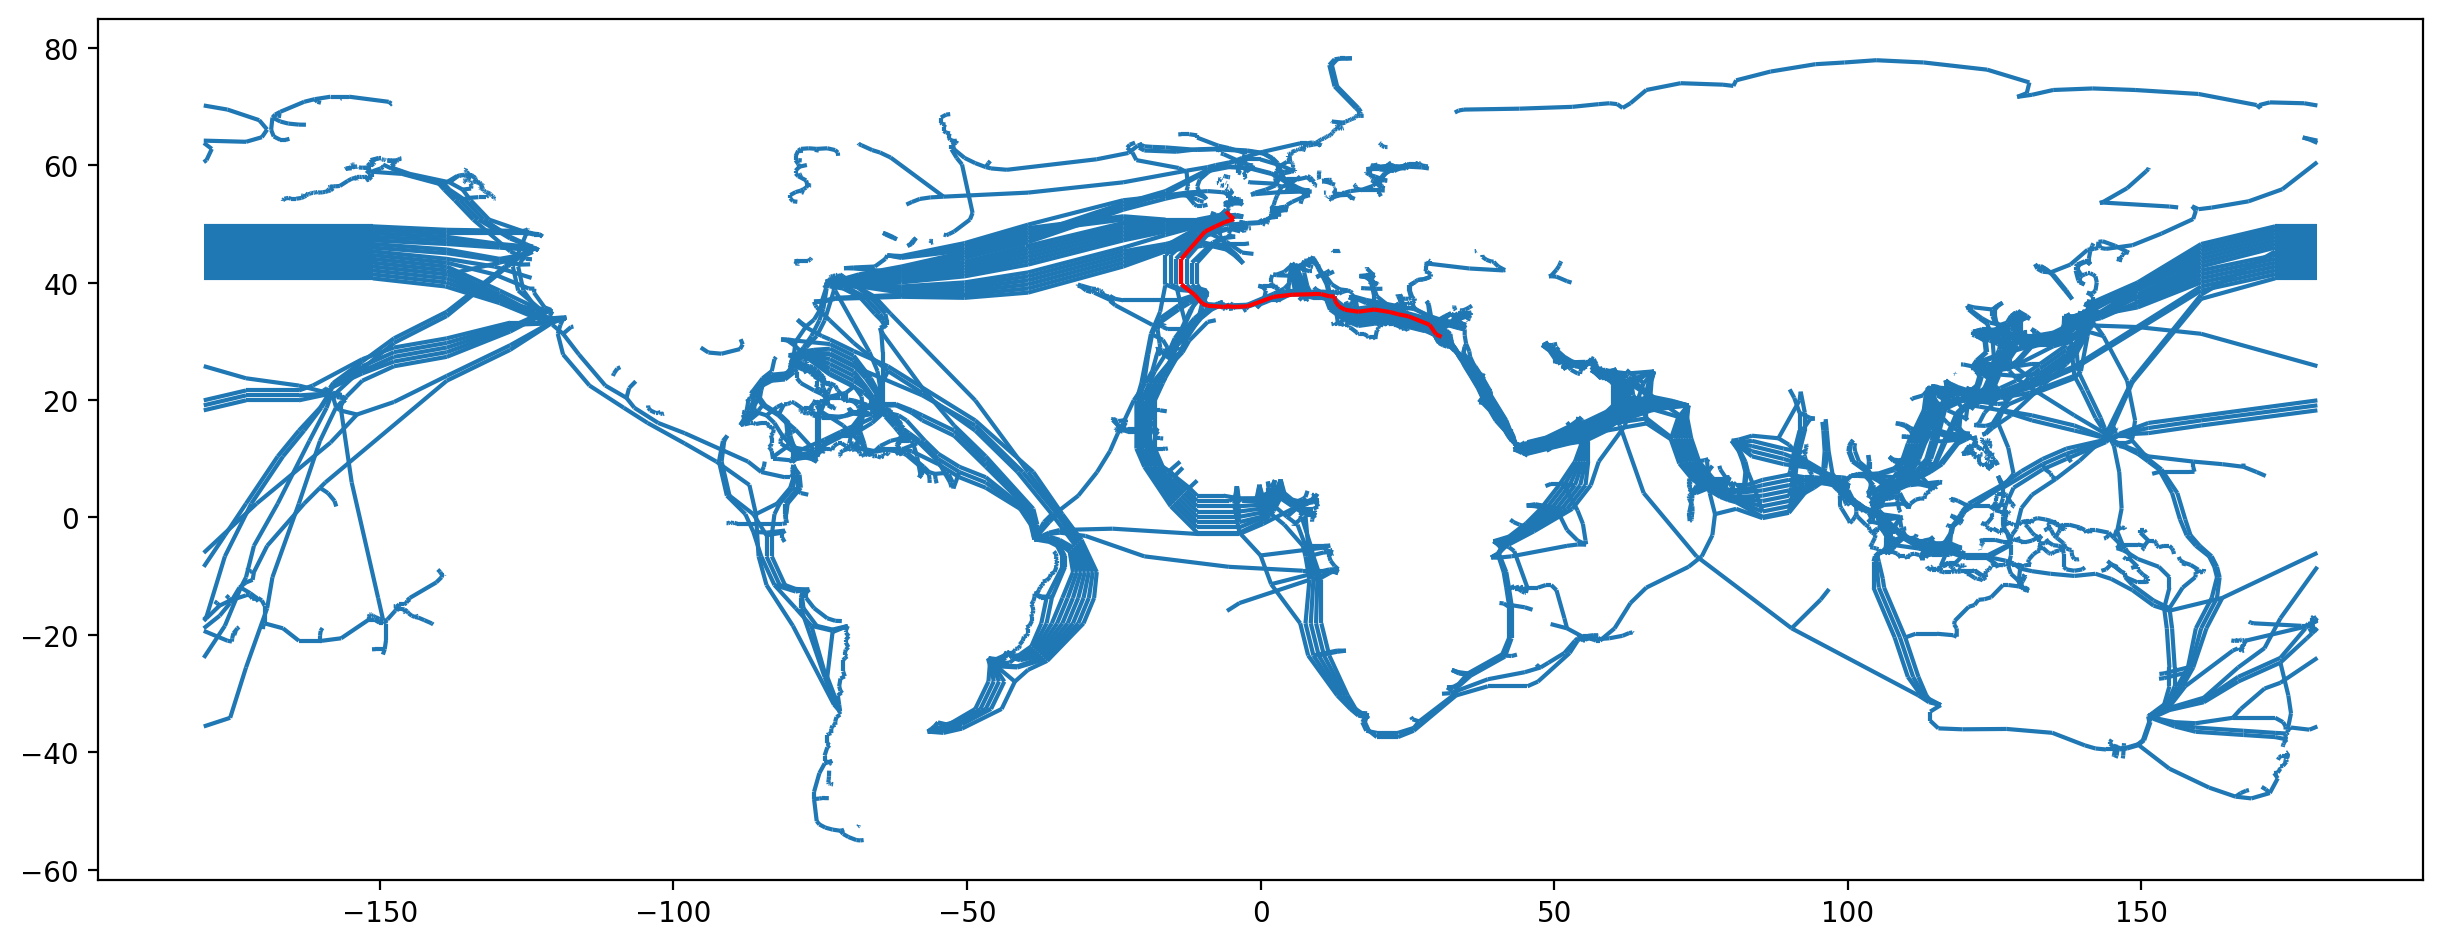

In [91]:
path = nx.shortest_path(G,6158154, 4629267, weight = 'length')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')


In [83]:
path_road

,index,lon1,lat1,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,line,geometry
5782,5783,30.825052,30.75649,29.893513,31.191465,POINT (30.82505 30.75649),POINT (29.89351 31.19147),6158154.0,6108498.0,1.02809,LINESTRING (30.825052399183477 30.756490442252...,"LINESTRING (30.82505 30.75649, 29.89351 31.19147)"
8470,8471,-5.347582,36.15602,-5.624922,35.922436,POINT (-5.34758 36.15602),POINT (-5.62492 35.92244),3080844.0,3029752.0,0.36260,LINESTRING (-5.347581975782816 36.156019514134...,"LINESTRING (-5.34758 36.15602, -5.62492 35.92244)"


In [14]:
# cable_shap.plot()

# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)
# cable_shap.plot(column='color', ax=ax, legend=True, cmap='Set2',aspect=1)


In [15]:
# landing_point = gpd.read_file("/Users/dijiongyuequ/Downloads/GitHub/UCL_Dessertation/Dataset/SubmarineCableMap/cable-geo.json")
# landing_point.to_csv("/Users/dijiongyuequ/Downloads/123.csv")